In [1]:
import pandas as pd
import numpy as np
import requests
import ast
import json
import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import datetime

from dotenv import load_dotenv


# LOAD ENV VARIABLES

In [ ]:
API_KEY_PATH = os.environ['API_KEY_PATH']

RESULTS_PATH = os.environ['RESULTS_PATH']
RANKINGS_PATH = os.environ['RANKINGS_PATH']
TEAMS_PATH = os.environ['TEAMS_PATH']
CALENDARS_PATH = os.environ['CALENDARS_PATH']
STARTLISTS_PATH = os.environ['STARTLISTS_PATH']
RACERESULTS_PATH = os.environ['RACERESULTS_PATH']
IMG_PATH = os.environ['IMG_PATH']
RIDERSTATS_PATH = os.environ['RIDERSTATS_PATH']

In [ ]:
with open(os.path.join(API_KEY_PATH, 'api_key.json'), 'r') as file:
    API_KEY = json.load(file)

# DEFINE FUNCTIONS

In [ ]:
def gm_distance_api(origins, destinations, API_KEY):
    
    output_format = 'json'

    avoid = 'highways'
    mode = 'BICYCLING'

    origins = str(origins[0]) + '%2C' + str(origins[1])
    if len(destinations) > 1:
        destinations = "".join([str(x[0]) + '%2C' + str(x[1]) + '%7C' for x in destinations])[:-3]
    else:
        destinations = str(destinations[0][0]) + '%2C' + str(destinations[0][1])

    url = f'https://maps.googleapis.com/maps/api/distancematrix/{output_format}?&avoid={avoid}&mode={mode}&destinations={destinations}&origins={origins}&key={API_KEY}'

    if len(url) > 2000:
        raise ValueError('URL TOO LONG')
    
    resp = requests.get(url)
    data = ast.literal_eval(resp.content.decode('utf-8'))
    
    distance = [x['distance']['value'] if x['status']=='OK' else x['status'] for x in data['rows'][0]['elements']]
    time = [x['duration']['value'] if x['status']=='OK' else x['status'] for x in data['rows'][0]['elements']]
    
    return {'origin_addresses': data['origin_addresses'],
            'destination_addresses': data['destination_addresses'],
            'distance': distance,
            'time': time}

# Define Coords

In [2]:
mandatory_checkpoints = {'st_imier_haut': (47.158679, 6.992699),
                         'st_imier_bas': ( 47.151270, 6.992830 ),
                         'lenzerheide_haut': (46.720930, 9.530324),
                         'lenzerheide_bas_lift': (46.724895, 9.547017),
                         'lenzerheide_bas_sporz': (46.715323, 9.540237),
                         'beckenried': (46.967084, 8.475212),
                         'gersau': (46.990807, 8.525738),
                         'goschenen': (46.665698, 8.588439),
                         'sanetsch': (46.363102, 7.295129)}

In [3]:
target_coords = {'versoix': (46.295182, 6.167042),
                 'mies': (46.296179, 6.168144),
                 'vaumarcus': (46.870955, 6.754053),
                 'chaux_de_fond': (47.122309, 6.885278),
                 'chasseral': (47.125755, 7.038184),
                 'delemont': (47.375549, 7.361500),
                 'liesberg': (47.397281, 7.400262),
                 'liesberg_2': (47.402422, 7.443518),
                 'basel': (47.535692, 7.609889),
                 'kaiseraugst': (47.536199, 7.721017),
                 'kaiserstuhl': (47.564849, 8.420254),
                 'aadorf': (47.494296, 8.894507),
                 'wil': (47.466492, 9.029698),
                 'herisau': (47.399475, 9.261252),
                 'appenzell': (47.355118, 9.354994),
                 'muhlehorn': (47.115214, 9.188269),
                 'kussnacht': (47.113982, 8.455709),
                 'boschenrot': (47.116249, 8.463129),
                 'horw': (46.998539, 8.311766),
                 'alpnach': (46.969442, 8.310239),
                 'airolo': (46.529486, 8.606202),
                 'rudlingen': (47.577124, 8.577448),
                 'kerzers': (46.976142, 7.195673),
                 'gsteig': (46.375759, 7.280778),
                 'henniez': (46.728007, 6.868603),
                 'sauge': (46.976480, 7.057238),
                 'nufenen': (46.477711, 8.389276),
                 'bern': (46.947277, 7.444190)
                 
}

In [4]:
checkpoints = mandatory_checkpoints.copy()
checkpoints.update(target_coords)

In [5]:
checkpoints

{'st_imier_haut': (47.158679, 6.992699),
 'st_imier_bas': (47.15127, 6.99283),
 'lenzerheide_haut': (46.72093, 9.530324),
 'lenzerheide_bas_lift': (46.724895, 9.547017),
 'lenzerheide_bas_sporz': (46.715323, 9.540237),
 'beckenried': (46.967084, 8.475212),
 'gersau': (46.990807, 8.525738),
 'goschenen': (46.665698, 8.588439),
 'sanetsch': (46.363102, 7.295129),
 'versoix': (46.295182, 6.167042),
 'mies': (46.296179, 6.168144),
 'vaumarcus': (46.870955, 6.754053),
 'chaux_de_fond': (47.122309, 6.885278),
 'chasseral': (47.125755, 7.038184),
 'delemont': (47.375549, 7.3615),
 'liesberg': (47.397281, 7.400262),
 'liesberg_2': (47.402422, 7.443518),
 'basel': (47.535692, 7.609889),
 'kaiseraugst': (47.536199, 7.721017),
 'kaiserstuhl': (47.564849, 8.420254),
 'aadorf': (47.494296, 8.894507),
 'wil': (47.466492, 9.029698),
 'herisau': (47.399475, 9.261252),
 'appenzell': (47.355118, 9.354994),
 'muhlehorn': (47.115214, 9.188269),
 'kussnacht': (47.113982, 8.455709),
 'boschenrot': (47.11624

- MISSING SAN GOTTARDO POINT

# Get API data

In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
api_data_time = {}
api_data_dist = {}

for cp, coord in checkpoints.items():
    
    destinations = checkpoints.copy()
    destinations.pop(cp)
    destinations = [x for x in destinations.values()]
    
    time = []
    distance = []
    if len(destinations) > 25:
        
        for chunk_destinations in chunks(destinations, 25):
            
            data = gm_distance_api(coord, chunk_destinations)
            time.extend(data['time'])
            distance.extend(data['distance'])
            
    else:
        
        data = gm_distance_api(coord, destinations)
        time.extend(data['time'])
        distance.extend(data['distance'])
    
    api_data_time[data['origin_addresses'][0]] = time
    api_data_dist[data['origin_addresses'][0]] = distance



In [ ]:
with open('./DIST_MATRIX/api_data_dist_02.json', 'w') as outfile:
    json.dump(api_data_dist, outfile)
    
with open('./DIST_MATRIX/api_data_time_02.json', 'w') as outfile:
    json.dump(api_data_time, outfile)
    
with open('./DIST_MATRIX/checkpoints_02.json', 'w') as outfile:
    json.dump(checkpoints, outfile)

# RUN CELL WITH DIFFERENT START POINTS TO GENERATE REPORTS


--------- Problem Data ------------
Instance Name      : test_2022.gtsp
Number of Vertices : 38
Number of Sets     : 32
Initial Tour       : Random
Maximum Removals   : 10
Trials             : 5
Restart Attempts   : 3
Rate of Adaptation : 0.5
Prob of Reopt      : 1.0
Maximum Time       : 360
Tour Budget        : None
-----------------------------------

 |1=====2=====3=====4=====5=====|  Cost = 81363  Time = 0.3 sec      

--------- Tour Summary ------------
Cost              : 81363
Total Time        : 0.28 sec
Solver Timeout?   : false
Tour is Feasible? : true
Output File       : /Users/kieranschubert/Desktop/such_optim/TOUR_FILES/tour_test_2022.txt
Tour Ordering     : printed to /Users/kieranschubert/Desktop/such_optim/TOUR_FILES/tour_test_2022.txt
-----------------------------------


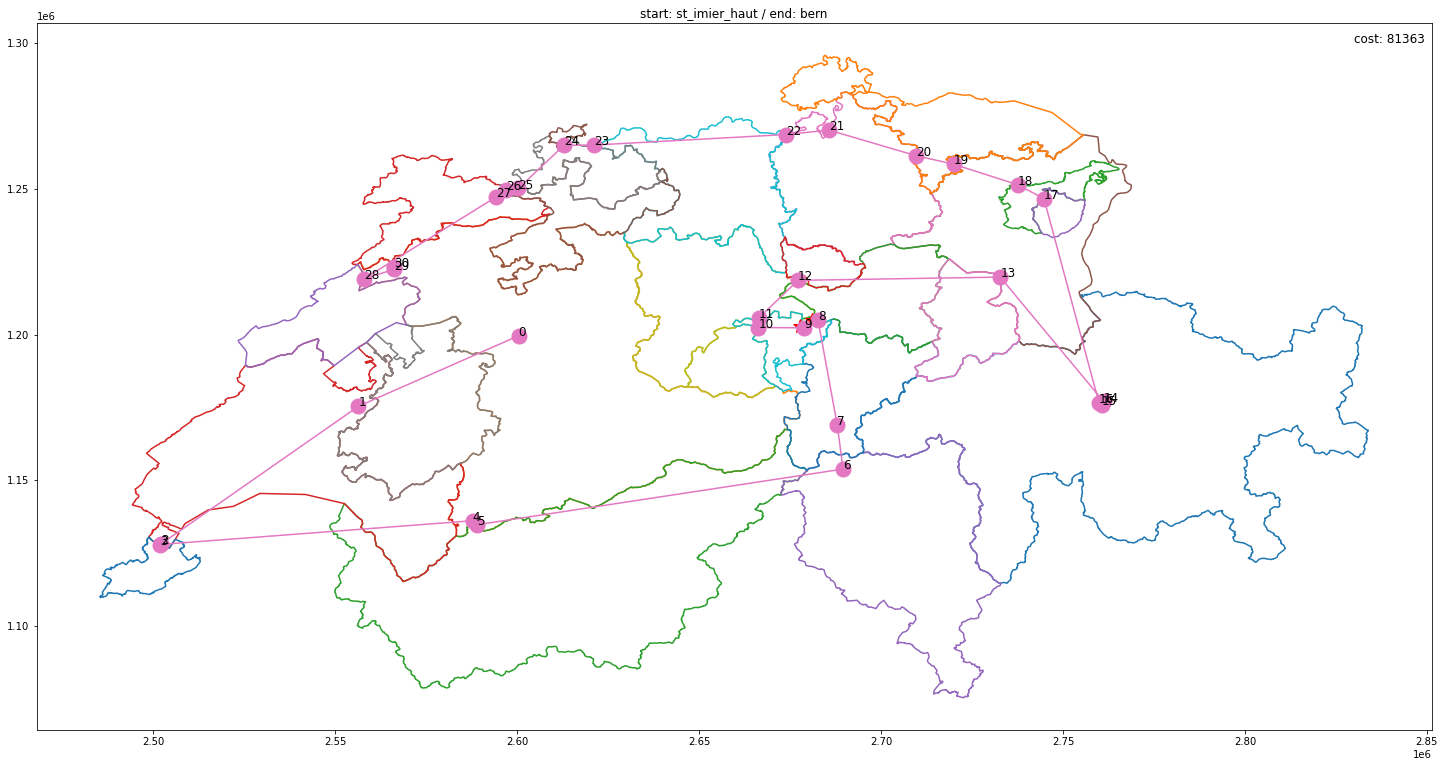


--------- Problem Data ------------
Instance Name      : test_2022.gtsp
Number of Vertices : 38
Number of Sets     : 32
Initial Tour       : Random
Maximum Removals   : 10
Trials             : 5
Restart Attempts   : 3
Rate of Adaptation : 0.5
Prob of Reopt      : 1.0
Maximum Time       : 360
Tour Budget        : None
-----------------------------------

 |1=====2=====3=====4=====5=====|  Cost = 81613  Time = 0.3 sec      

--------- Tour Summary ------------
Cost              : 81613
Total Time        : 0.27 sec
Solver Timeout?   : false
Tour is Feasible? : true
Output File       : /Users/kieranschubert/Desktop/such_optim/TOUR_FILES/tour_test_2022.txt
Tour Ordering     : printed to /Users/kieranschubert/Desktop/such_optim/TOUR_FILES/tour_test_2022.txt
-----------------------------------


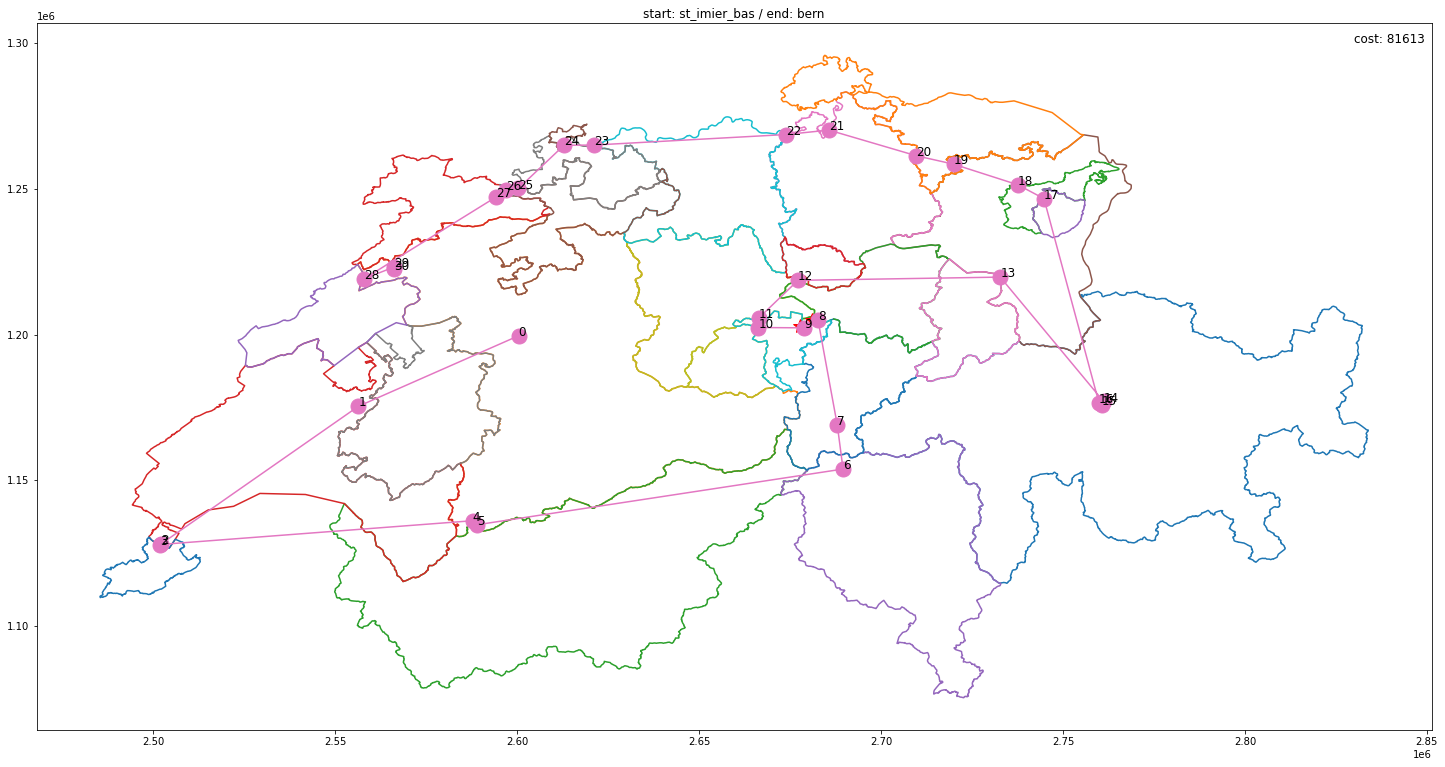

In [11]:
reports = []
reports_r = []

for start_point in list(mandatory_checkpoints.keys())[:2]:
    
    ###########################################################################
    ### TIME
    with open('./DIST_MATRIX/api_data_time_02.json', 'r') as file:
        api_data = json.load(file)

    ### DIST
    #with open('./DIST_MATRIX/api_data_dist_00.json', 'r') as file:
    #    api_data = json.load(file)
    ###########################################################################

    df = pd.DataFrame(np.zeros((len(api_data.keys()), len(api_data.keys()))))

    for i, (key, val) in enumerate(api_data.items()):

        df.loc[i, i] = 999999
        df.loc[i, np.where(df.loc[i]!=999999)[0]] = val


    df.replace({'ZERO_RESULTS': 999999}, inplace=True)

    ###########################################################################
    # GM TRANSPORT CORRECTIONS
    # ST IMIER
    df.loc[0, 1] = 320
    df.loc[1, 0] = 300

    # LENZERHEIDE TGANTIENI-LIFT
    df.loc[2, 3] = 240
    df.loc[3, 2] = 300

    # LENZERHEIDE TGANTIENI-SPORZ
    df.loc[2, 4] = 90
    df.loc[4, 2] = 500

    # LENZERHEIDE LIFT-SPORZ
    df.loc[3, 4] = 480
    df.loc[4, 3] = 120

    # LENZERHEIDE BECKENRIED-GERSAU
    df.loc[5, 6] = 1200
    df.loc[6, 5] = 1200

    # LENZERHEIDE GOSCHENEN-AIROLO
    df.loc[7, 29] = 900
    df.loc[29, 7] = 4500

    # LENZERHEIDE SANETSCH-GSTEIG
    df.loc[8, 32] = 900
    df.loc[32, 8] = 16200
    ###########################################################################

    df[len(df)] = 999999
    df.loc[len(df)] = 999999

    start = start_point
    ind_start = [x==start for x in checkpoints.keys()]
    ind_start = np.where(ind_start)[0][0]

    end = 'bern'
    ind_end = [x==end for x in checkpoints.keys()]
    ind_end = np.where(ind_end)[0][0]

    # 0 for dummy-dummy
    df.loc[len(df)-1, len(df)-1] = 0

    # 0 for start-end and end-start
    df.loc[ind_start, len(df)-1] = 0
    df.loc[ind_end, len(df)-1] = 0
    df.loc[len(df)-1, ind_start] = 0
    df.loc[len(df)-1, ind_end] = 0

    df = df.astype('int')
    ###########################################################################
    
    such_2022 = pd.DataFrame([x for x in checkpoints.values()])
    such_2022 = such_2022.append([(45, 6.9)])

    such_2022['cluster'] = ['BE1', 'BE2', 'GR1', 'GR2', 'GR3', 'NW', 'SZ', 'UR', 'VS', 'GE', 'VD', 'NE', 'NE', 'NE', 'JU', 'BL', 'SO', 'BS', 'AG', 'ZH', 'TG', 'SG', 'AR', 'AI', 'GL', 'ZG', 'LU', 'LU', 'OW', 'TI', 'SH', 'FR', 'BE', 'FR', 'FR', 'TI', 'END', 'DUMMY']

    cluster_mapping = {'ZH': 1,
                      'BE1': 2,
                      'BE2': 3,
                      'LU': 4,
                      'UR': 5,
                      'SZ': 6,
                      'OW': 7,
                      'NW': 8,
                      'GL': 9,
                      'ZG': 10,
                      'FR': 11,
                      'SO': 12,
                      'BS': 13,
                      'BL': 14,
                      'SH': 15,
                      'AR': 16,
                      'AI': 17,
                      'SG': 18,
                      'GR1': 19,
                      'GR2': 20,
                      'GR3': 21,
                      'AG': 22,
                      'TG': 23,
                      'TI': 24,
                      'VD': 25,
                      'VS': 26,
                      'NE': 27,
                      'GE': 28,
                      'JU': 29,
                      'BE': 30,
                      'END': 31,
                      'DUMMY': 32}

    such_2022.replace(cluster_mapping, inplace=True)
    such_2022.reset_index(drop=True, inplace=True)

    clusters = such_2022.groupby(by='cluster')
    clusters = [(cluster[0], [x+1 for x in list(cluster[1].index)]) for cluster in clusters]
    ###########################################################################

    try:
        os.remove('./GTSP_FILES/test_2022.gtsp')
    except FileNotFoundError:
        pass

    dim = len(df)
    sets = len(clusters)

    # WRITE PARAMS AND WEIGHTS TO FILE
    params = f'NAME: such_test_3 \n\
    TYPE: AGTSP \n\
    COMMENT: test \n\
    DIMENSION: {dim} \n\
    GTSP_SETS: {sets} \n\
    EDGE_WEIGHT_TYPE: EXPLICIT \n\
    EDGE_WEIGHT_FORMAT: FULL_MATRIX \n\
    EDGE_WEIGHT_SECTION \n\
    {df.to_string(header=False, index=False)} \n\
    GTSP_SET_SECTION: \n'

    with open('./GTSP_FILES/test_2022.gtsp', 'a') as gtsp_file:
        gtsp_file.write(params)

    # WRITE SET SECTION
    outfile = open('./GTSP_FILES/test_2022.gtsp', 'a')

    for cluster in clusters:
        out = str(cluster[0]) + ' ' + ' '.join([str(x) for x in cluster[1]]) + ' -1' + '\n'
        outfile.write(out)

    outfile.close()

    # WRITE EOF
    with open('./GTSP_FILES/test_2022.gtsp', 'a') as gtsp_file:
        gtsp_file.write('EOF')
    ###########################################################################

    !/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia ./gtsp_solver.jl
    
    ###########################################################################

    with open('./TOUR_FILES/tour_test_2022.txt') as f:
        file = f.readlines()

    tour = ast.literal_eval(file[-1].split(": ")[-1])
    tour = [x-1 for x in tour]

    tour_cost = file[6].split(': ')[-1].strip()

    df_cantons = gpd.read_file("./swissboundaries/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp")
    cantons = df_cantons['NAME'].unique()

    cp_coord_x = [2588950.069, 2677691.166, 2680954.976, 2688009.628, 2566249.259, 2759952.968, 2600422.411]
    cp_coord_y = [1134641.528, 1202811.284, 1205098.173, 1168980.565, 1223196.312, 1176579.977, 1199574.686]

    ###########################################################################
    try:
        df_tour = such_2022.loc[tour].replace({v: k for k, v in cluster_mapping.items()}).iloc[::-1]

        df_1 = df_tour.loc[df_tour[df_tour.cluster == 'DUMMY'].index[0]:].iloc[1:]
        df_2 = df_tour.loc[:df_tour[df_tour.cluster == 'DUMMY'].index[0]].iloc[:-1]
        df_tour = pd.concat([df_1, df_2])

        df_tour.replace({0: 'latitude', 1: 'longitude'}, inplace=True)

        such_2022 = such_2022.rename(columns={0: 'latitude', 1: 'longitude'})

        tour_coord_x = []
        tour_coord_y = []

        # need to reverse df order SOMETIMES
        for i, coords in df_tour.iterrows():
        #for i, coords in such_2022.loc[tour].iterrows():

            url = f'http://geodesy.geo.admin.ch/reframe/wgs84tolv95?easting={coords.longitude}&northing={coords.latitude}&format=json'
            res = requests.get(url)
            res = ast.literal_eval(res.content.decode('utf-8'))
            tour_coord_y.append(res['northing'])
            tour_coord_x.append(res['easting'])

        tour_coord_x = [float(x) for x in tour_coord_x]
        tour_coord_y = [float(y) for y in tour_coord_y]

    except:
        df_tour = such_2022.loc[tour].replace({v: k for k, v in cluster_mapping.items()}).iloc[::-1]

        df_1 = df_tour.loc[df_tour[df_tour.cluster == 'DUMMY'].index[0]:].iloc[1:]
        df_2 = df_tour.loc[:df_tour[df_tour.cluster == 'DUMMY'].index[0]].iloc[:-1]
        df_tour = pd.concat([df_1, df_2])

        df_tour.replace({0: 'latitude', 1: 'longitude'}, inplace=True)

        such_2022 = such_2022.rename(columns={0: 'latitude', 1: 'longitude'})

        tour_coord_x = []
        tour_coord_y = []

        # need to reverse df order SOMETIMES
        for i, coords in df_tour.iterrows():
        #for i, coords in such_2022.loc[tour].iterrows():

            url = f'http://geodesy.geo.admin.ch/reframe/wgs84tolv95?easting={coords.longitude}&northing={coords.latitude}&format=json'
            res = requests.get(url)
            res = ast.literal_eval(res.content.decode('utf-8'))
            tour_coord_y.append(res['northing'])
            tour_coord_x.append(res['easting'])

        tour_coord_x = [float(x) for x in tour_coord_x]
        tour_coord_y = [float(y) for y in tour_coord_y]

    ###########################################################################
    fig, ax = plt.subplots(figsize=(25,13))

    for canton in cantons:
        x_c, y_c = df_cantons[df_cantons['NAME']==canton]['geometry'].iloc[0].exterior.coords.xy
        x_c = list(x_c)[:-1]
        y_c = list(y_c)[:-1]
        ax.plot(x_c, y_c)

    ax.plot(cp_coord_x, cp_coord_y, 'r*', markersize=15)

    ax.plot(tour_coord_x, tour_coord_y, '-o', markersize=15)

    for i, (x, y) in enumerate(zip(tour_coord_x, tour_coord_y)):

        ax.text(x, y, i, fontsize='large')

    ax.text(2830000, 1300000, f'cost: {tour_cost}', fontsize='large')
    ax.set_title(f'start: {start} / end: {end}')

    #plt.savefig(f'./TOUR_VIZ/2022/WITHOUT_TRANSPORT/{start}_{end}_{tour_cost}.png')
    plt.show()
    ###########################################################################

    cp_opening_times = {'st_imier_bas': [datetime.datetime.strptime('7/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                     datetime.datetime.strptime('7/9/2022 23:10', '%d/%m/%Y %H:%M'),
                                     datetime.datetime.strptime('8/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                     datetime.datetime.strptime('8/9/2022 23:10', '%d/%m/%Y %H:%M')],
                        'st_imier_haut': [datetime.datetime.strptime('7/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                     datetime.datetime.strptime('7/9/2022 23:10', '%d/%m/%Y %H:%M'),
                                     datetime.datetime.strptime('8/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                     datetime.datetime.strptime('8/9/2022 23:10', '%d/%m/%Y %H:%M')], 
                        'lenzerheide_haut': [datetime.datetime.strptime('7/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                        datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                        datetime.datetime.strptime('8/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                        datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')],
                        'lenzerheide_bas_lift': [datetime.datetime.strptime('7/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                        datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                        datetime.datetime.strptime('8/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                        datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')],
                        'lenzerheide_bas_sporz': [datetime.datetime.strptime('7/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                        datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                        datetime.datetime.strptime('8/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                        datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')],
                        'beckenried': [datetime.datetime.strptime('7/9/2022 07:40', '%d/%m/%Y %H:%M'),
                                       datetime.datetime.strptime('7/9/2022 18:40', '%d/%m/%Y %H:%M'),
                                       datetime.datetime.strptime('8/9/2022 07:40', '%d/%m/%Y %H:%M'),
                                       datetime.datetime.strptime('8/9/2022 18:40', '%d/%m/%Y %H:%M')],
                        'gersau': [datetime.datetime.strptime('7/9/2022 07:00', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('7/9/2022 18:00', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('8/9/2022 07:00', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('8/9/2022 18:00', '%d/%m/%Y %H:%M')],
                        'goschenen': [datetime.datetime.strptime('7/9/2022 06:51', '%d/%m/%Y %H:%M'),
                                      datetime.datetime.strptime('7/9/2022 21:51', '%d/%m/%Y %H:%M'),
                                      datetime.datetime.strptime('8/9/2022 06:51', '%d/%m/%Y %H:%M'),
                                      datetime.datetime.strptime('8/9/2022 21:51', '%d/%m/%Y %H:%M')],
                        'sanetsch': [datetime.datetime.strptime('7/9/2022 08:30', '%d/%m/%Y %H:%M'),
                                     datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                     datetime.datetime.strptime('8/9/2022 08:30', '%d/%m/%Y %H:%M'),
                                     datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')]}

    ###########################################################################
    ### DIST
    with open('./DIST_MATRIX/api_data_dist_02.json', 'r') as file:
        api_data = json.load(file)

    ###########################################################################
    df_transport = pd.DataFrame(np.zeros((len(api_data.keys()), len(api_data.keys()))))

    for i, (key, val) in enumerate(api_data.items()):

        df_transport.loc[i, i] = 999999
        df_transport.loc[i, np.where(df_transport.loc[i]!=999999)[0]] = val


    df_transport.replace({'ZERO_RESULTS': 999999}, inplace=True)
    
    ###########################################################################

    def getRouteReport(df_tour, df_transport, avg_speed, reverse=False):

        # sometimes tour is reversed by solver, un-reverse it
        if reverse:
            df_tour = df_tour.iloc[::-1]
            
        df_tour_eta = df_tour.copy()
        
        # compute slices of 2 for each 2 consecutive points in route
        n = 2  # group size
        m = 1  # overlap size
        l = list(df_tour.index)
        tour_slices = [l[i:i+n] for i in range(0, len(l), n-m)][:-1]

        # compute dist between two points in route
        dist = []
        for ind in tour_slices:

            dist.append(df_transport.iloc[ind[0], ind[1]])

        # transform to km
        dist = [x/1000 for x in dist]
        df_tour_eta['dist_km'] = np.insert(dist, 0, 0)
        
        # compute cum dist
        cum_dist = np.cumsum((dist))
        df_tour_eta['cum_dist_km'] = np.insert(cum_dist, 0, 0)
        
        # compute time between two points
        df_tour_eta['time_h'] = np.insert([x/avg_speed for x in dist], 0, 0)
        
        # compute elapsed time for given avg speed
        elapsed_time = np.cumsum([x/avg_speed for x in dist])
        df_tour_eta['elapsed_time_h'] = np.insert(elapsed_time, 0, 0)
        
        # define start datetime
        start_time = datetime.datetime.strptime('7/9/2022 10:10', '%d/%m/%Y %H:%M')

        # compute eta at cp
        eta_timestamp_dt = [(start_time + datetime.timedelta(hours=t)) for t in elapsed_time]
        df_tour_eta['eta'] = np.insert(eta_timestamp_dt, 0, start_time)
        
        # compute elapsed time in human readable format
        df_tour_eta['elapsed_time_hrf'] = df_tour_eta.eta.diff().fillna(pd.Timedelta(seconds=0)).cumsum()
      
        # get name of towns (non-mandatory cp)
        checkpoints_r = {v: k for k,v in checkpoints.items()}
        df_tour_eta['cp'] = [checkpoints_r[(lat, lon)] for lat, lon in zip(df_tour_eta['latitude'], df_tour_eta['longitude'])]
        
        # get opening hours for transportation at cps
        mc = {v: k for k, v in mandatory_checkpoints.items()}
        opening_hours = [cp_opening_times[mc[(lat, lon)]] if (lat, lon) in list(mc.keys()) else np.nan for lat, lon in zip(df_tour_eta['latitude'], df_tour_eta['longitude'])]
        df_tour_eta['opening_hours'] = opening_hours

        # infer if transportation at cp is open
        df_tour_eta['transport'] = ['Y' if (oh is not np.nan) and ((oh[0] < ts < oh[1]) or (oh[2] < ts < oh[3])) else np.nan for ts, oh in zip(df_tour_eta['eta'], df_tour_eta['opening_hours'])]

        return df_tour_eta

    ###########################################################################
    reports.append(getRouteReport(df_tour, df_transport, avg_speed=26, reverse=False))
    reports_r.append(getRouteReport(df_tour, df_transport, avg_speed=26, reverse=True))

In [17]:
reports[1]

,latitude,longitude,cluster,dist_km,cum_dist_km,time_h,elapsed_time_h,eta,elapsed_time_hrf,cp,opening_hours,transport
36,46.947277,7.444190,END,0.000,0.000,0.000000,0.000000,2022-09-07 10:10:00.000000,0 days 00:00:00,bern,NaN,NaN
33,46.728007,6.868603,FR,60.894,60.894,2.342077,2.342077,2022-09-07 12:30:31.476923,0 days 02:20:31.476923,henniez,NaN,NaN
10,46.296179,6.168144,VD,84.878,145.772,3.264538,5.606615,2022-09-07 15:46:23.815385,0 days 05:36:23.815385,mies,NaN,NaN
9,46.295182,6.167042,GE,0.522,146.294,0.020077,5.626692,2022-09-07 15:47:36.092308,0 days 05:37:36.092308,versoix,NaN,NaN
32,46.375759,7.280778,BE,123.256,269.550,4.740615,10.367308,2022-09-07 20:32:02.307692,0 days 10:22:02.307692,gsteig,NaN,NaN
8,46.363102,7.295129,VS,113.098,382.648,4.349923,14.717231,2022-09-08 00:53:02.030769,0 days 14:43:02.030769,sanetsch,"[2022-09-07 08:30:00, 2022-09-07 17:00:00, 202...",NaN
29,46.529486,8.606202,TI,159.263,541.911,6.125500,20.842731,2022-09-08 07:00:33.830769,0 days 20:50:33.830769,airolo,NaN,NaN
7,46.665698,8.588439,UR,31.255,573.166,1.202115,22.044846,2022-09-08 08:12:41.446154,0 days 22:02:41.446154,goschenen,"[2022-09-07 06:51:00, 2022-09-07 21:51:00, 202...",Y
6,46.990807,8.525738,SZ,51.570,624.736,1.983462,24.028308,2022-09-08 10:11:41.907692,1 days 00:01:41.907692,gersau,"[2022-09-07 07:00:00, 2022-09-07 18:00:00, 202...",Y
5,46.967084,8.475212,NW,7.313,632.049,0.281269,24.309577,2022-09-08 10:28:34.476923,1 days 00:18:34.476923,beckenried,"[2022-09-07 07:40:00, 2022-09-07 18:40:00, 202...",Y


- SET ALL TRANSPORTS TO ON
- THEN TEST ALL COMBINATIONS OF TRANSPORTS
- THEN SET ALL DIFFERENT DEPARTURE POINTS

- SUBTRACT TIME FOR TRANSPORTS
- RANK BEST ROUTES WRT TOTAL TIME
- ADD TARGET POINTS -> MAYBE WILL HELP FOR GSTEIG IF MORE POINTS IN BE

- compute all optimal routes from all possible start points
- for the shortest routes, compute all possible pairs of transports -> then check eta and feasability
- for the shortest routes, compute eta at each stop -> see if transport is feasible

- OTHER APPROACH: encore transport in distance matrix

- ELEVATION API ? 
- REQUIRE HALF MATRIX (SYMMETRY)
- COMPUTE DIFF(ALT1, ALT2) BETWEEN 2 POINTS
- ESTIMATE SPEEDS FOR ALL GRADIENTS -> DYNAMIC SPEED COMPUTATION

# CP TRANSPORTATION

In [ ]:
cp_transportation_time_costs = {'st_imier': 300,
                           'lenzerheide': 300,
                           'beckenried': 1200,
                           'gersau': 1200,
                           'goschenen': 900,
                           'sanetsch': 900}

### Set desired transportation

In [ ]:
cp1 = 'lenzerheide'
cp1_p = 'airolo'
cp2 = 'beckenried'
cp2_p = 'beckenried'

### Set cost to 0 in desired direction

In [ ]:
ind_cp1 = [x==cp1 for x in checkpoints.keys()]
ind_cp1 = np.where(ind_cp1)[0][0]
ind_cp1_p = [x==cp1_p for x in checkpoints.keys()]
ind_cp1_p = np.where(ind_cp1_p)[0][0]

ind_cp2 = [x==cp2 for x in checkpoints.keys()]
ind_cp2 = np.where(ind_cp2)[0][0]
ind_cp2_p = [x==cp2_p for x in checkpoints.keys()]
ind_cp2_p = np.where(ind_cp2_p)[0][0]

In [ ]:
# Set asymetric transportation cost
df.loc[ind_cp1, ind_cp1_p] = cp_transportation_time_costs[cp1]
df.loc[ind_cp2, ind_cp2_p] = cp_transportation_time_costs[cp2]

### Re-run optimisation

In [ ]:
try:
    os.remove('./GTSP_FILES/test_2022.gtsp')
except FileNotFoundError:
    pass

dim = len(df)
sets = len(clusters)

# WRITE PARAMS AND WEIGHTS TO FILE
params = f'NAME: such_test_3 \n\
TYPE: AGTSP \n\
COMMENT: test \n\
DIMENSION: {dim} \n\
GTSP_SETS: {sets} \n\
EDGE_WEIGHT_TYPE: EXPLICIT \n\
EDGE_WEIGHT_FORMAT: FULL_MATRIX \n\
EDGE_WEIGHT_SECTION \n\
{df.to_string(header=False, index=False)} \n\
GTSP_SET_SECTION: \n'

with open('./GTSP_FILES/test_2022.gtsp', 'a') as gtsp_file:
    gtsp_file.write(params)

# WRITE SET SECTION
outfile = open('./GTSP_FILES/test_2022.gtsp', 'a')

for cluster in clusters:
    out = str(cluster[0]) + ' ' + ' '.join([str(x) for x in cluster[1]]) + ' -1' + '\n'
    outfile.write(out)

outfile.close()

# WRITE EOF
with open('./GTSP_FILES/test_2022.gtsp', 'a') as gtsp_file:
    gtsp_file.write('EOF')

In [ ]:
!/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia ./gtsp_solver.jl

In [ ]:
with open('./TOUR_FILES/tour_test_2022.txt') as f:
    file = f.readlines()
    
tour = ast.literal_eval(file[-1].split(": ")[-1])
tour = [x-1 for x in tour]

tour_cost = file[6].split(': ')[-1].strip()

df_cantons = gpd.read_file("./swissboundaries/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp")
cantons = df_cantons['NAME'].unique()

cp_coord_x = [2588950.069, 2677691.166, 2680954.976, 2688009.628, 2566249.259, 2759952.968, 2600422.411]
cp_coord_y = [1134641.528, 1202811.284, 1205098.173, 1168980.565, 1223196.312, 1176579.977, 1199574.686]

In [ ]:
df_tour = such_2022.loc[tour].replace({v: k for k, v in cluster_mapping.items()}).iloc[::-1]

df_1 = df_tour.loc[df_tour[df_tour.cluster == 'DUMMY'].index[0]:].iloc[1:]
df_2 = df_tour.loc[:df_tour[df_tour.cluster == 'DUMMY'].index[0]].iloc[:-1]
df_tour = pd.concat([df_1, df_2])

df_tour.replace({0: 'latitude', 1: 'longitude'}, inplace=True)

such_2022.rename(columns={0: 'latitude', 1: 'longitude'}, inplace=True)

tour_coord_x = []
tour_coord_y = []

# need to reverse df order SOMETIMES
for i, coords in df_tour.iterrows():
#for i, coords in such_2022.loc[tour].iterrows():

    url = f'http://geodesy.geo.admin.ch/reframe/wgs84tolv95?easting={coords.longitude}&northing={coords.latitude}&format=json'
    res = requests.get(url)
    res = ast.literal_eval(res.content.decode('utf-8'))
    tour_coord_y.append(res['northing'])
    tour_coord_x.append(res['easting'])
    
tour_coord_x = [float(x) for x in tour_coord_x]
tour_coord_y = [float(y) for y in tour_coord_y]

### WITH TRANSPORT

In [ ]:
fig, ax = plt.subplots(figsize=(25,13))

for canton in cantons:
    x_c, y_c = df_cantons[df_cantons['NAME']==canton]['geometry'].iloc[0].exterior.coords.xy
    x_c = list(x_c)[:-1]
    y_c = list(y_c)[:-1]
    ax.plot(x_c, y_c)

ax.plot(cp_coord_x, cp_coord_y, 'r*', markersize=15)
    
ax.plot(tour_coord_x, tour_coord_y, '-o', markersize=15)

for i, (x, y) in enumerate(zip(tour_coord_x, tour_coord_y)):
    
    ax.text(x, y, i, fontsize='large')
    
ax.text(2830000, 1300000, f'cost: {tour_cost}', fontsize='large')
ax.set_title(f'start: {start} / end: {end}')

plt.savefig(f'./TOUR_VIZ/2022/WITH_TRANSPORT/{start}_{end}_{tour_cost}_t1_{cp1}_t2_{cp2}.png')
plt.show()

# TRANSPORTATION ETA CHECK

In [ ]:
cp_opening_times = {'st_imier': [datetime.datetime.strptime('7/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('7/9/2022 23:10', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 06:35', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 23:10', '%d/%m/%Y %H:%M')], 
                    'lenzerheide': [datetime.datetime.strptime('7/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('8/9/2022 09:00', '%d/%m/%Y %H:%M'),
                                    datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')],
                    'beckenried': [datetime.datetime.strptime('7/9/2022 07:40', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('7/9/2022 18:40', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('8/9/2022 07:40', '%d/%m/%Y %H:%M'),
                                   datetime.datetime.strptime('8/9/2022 18:40', '%d/%m/%Y %H:%M')],
                    'gersau': [datetime.datetime.strptime('7/9/2022 07:00', '%d/%m/%Y %H:%M'),
                               datetime.datetime.strptime('7/9/2022 18:00', '%d/%m/%Y %H:%M'),
                               datetime.datetime.strptime('8/9/2022 07:00', '%d/%m/%Y %H:%M'),
                               datetime.datetime.strptime('8/9/2022 18:00', '%d/%m/%Y %H:%M')],
                    'goschenen': [datetime.datetime.strptime('7/9/2022 06:51', '%d/%m/%Y %H:%M'),
                                  datetime.datetime.strptime('7/9/2022 21:51', '%d/%m/%Y %H:%M'),
                                  datetime.datetime.strptime('8/9/2022 06:51', '%d/%m/%Y %H:%M'),
                                  datetime.datetime.strptime('8/9/2022 21:51', '%d/%m/%Y %H:%M')],
                    'sanetsch': [datetime.datetime.strptime('7/9/2022 08:30', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('7/9/2022 17:00', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 08:30', '%d/%m/%Y %H:%M'),
                                 datetime.datetime.strptime('8/9/2022 17:00', '%d/%m/%Y %H:%M')]}

In [ ]:
### DIST
with open('./DIST_MATRIX/api_data_dist_00.json', 'r') as file:
    api_data = json.load(file)
    
df_transport = pd.DataFrame(np.zeros((len(api_data.keys()), len(api_data.keys()))))

for i, (key, val) in enumerate(api_data.items()):
    
    df_transport.loc[i, i] = 999999
    df_transport.loc[i, np.where(df_transport.loc[i]!=999999)[0]] = val
    

df_transport.replace({'ZERO_RESULTS': 999999}, inplace=True)

In [ ]:
n = 2  # group size
m = 1  # overlap size
l = list(df_tour.index)
tour_slices = [l[i:i+n] for i in range(0, len(l), n-m)][:-1]

# COMPUTE ETA AT CP
cum_dist = []
for ind in tour_slices:
    
    cum_dist.append(df_transport.iloc[ind[0], ind[1]])

avg_speed = 26
eta = np.cumsum([x/1000/avg_speed for x in cum_dist])

In [ ]:
def getRouteReport(df_tour):

    df_tour_eta = df_tour.copy()

    df_tour_eta['eta'] = np.insert(eta, 0, 0)
    start_time = datetime.datetime.strptime('7/9/2022 10:10', '%d/%m/%Y %H:%M')

    eta_timestamp_dt = [(start_time + datetime.timedelta(hours=t)) for t in eta]
    df_tour_eta['timestamp_dt'] = np.insert(eta_timestamp_dt, 0, start_time)

    df_tour_eta['elapsed_time'] = df_tour_eta.timestamp_dt.diff().fillna(pd.Timedelta(seconds=0)).cumsum()

    mc = {v: k for k, v in mandatory_checkpoints.items()}
    df_tour_eta['cp'] = [mc[(lat, lon)] if (lat, lon) in list(mandatory_checkpoints.values()) else np.nan for lat, lon in zip(df_tour_eta['latitude'], df_tour_eta['longitude'])]

    opening_hours = [cp_opening_times[mc[(lat, lon)]] if (lat, lon) in list(mc.keys()) else np.nan for lat, lon in zip(df_tour_eta['latitude'], df_tour_eta['longitude'])]
    df_tour_eta['opening_hours'] = opening_hours

    df_tour_eta['transport'] = ['Y' if (oh is not np.nan) and ((oh[0] < ts < oh[1]) or (oh[2] < ts < oh[3])) else np.nan for ts, oh in zip(df_tour_eta['timestamp_dt'], df_tour_eta['opening_hours'])]

    return df_tour_eta

In [ ]:
getRouteReport(df_tour)

In [ ]:
cp_transportation_dist_costs ={'st_imier': 2083,
                           'lenzerheide': 2083,
                           'beckenried': 8330,
                           'gersau': 8330,
                           'goschenen': 6250,
                           'sanetsch': 8330} 

In [ ]:
df_transport.loc[ind_cp1, ind_cp1_p] = cp_transportation_dist_costs[cp1]
df_transport.loc[ind_cp2, ind_cp2_p] = cp_transportation_dist_costs[cp2]

In [ ]:
pos_in_tour = np.where(df_tour.iloc[::-1].index==ind_cp1)[0]
start_time = datetime.datetime.strptime('7/9/2022 10:10', '%d/%m/%Y %H:%M')

# if cp at start, set cum_time to 0
if pos_in_tour-1 == -1:
    pos_in_tour = 0
    cp1_eta = start_time
else:
    cp1_eta = start_time + datetime.timedelta(hours=eta[pos_in_tour-1][0])
    

cp1_ontime = (cp_opening_times[cp1][0] < cp1_eta < cp_opening_times[cp1][1]) or (cp_opening_times[cp1][2] < cp1_eta < cp_opening_times[cp1][3])
cp1_ontime

In [ ]:
cp1_eta.strftime('%d/%m/%Y %H:%M')

In [ ]:
pos_in_tour = np.where(df_tour.iloc[::-1].index==ind_cp2)[0]

# if cp at start, set cum_time to 0
if pos_in_tour-1 == -1:
    pos_in_tour = 0
    cp2_eta = start_time
else:
    cp2_eta = start_time + datetime.timedelta(hours=eta[pos_in_tour-1][0])
    
cp2_ontime = (cp_opening_times[cp2][0] < cp2_eta < cp_opening_times[cp2][1]) or (cp_opening_times[cp2][2] < cp2_eta < cp_opening_times[cp2][3])
cp2_ontime

In [ ]:
cp2_eta.strftime('%d/%m/%Y %H:%M')

In [ ]:
transportation_eta = {'cp1': cp1,
                      'cp1_eta': cp1_eta.strftime('%d/%m/%Y %H:%M'),
                      'cp1_on_time': cp1_ontime,
                      'cp2': cp2,
                      'cp2_eta': cp2_eta.strftime('%d/%m/%Y %H:%M'),
                      'cp2_on_time': cp2_ontime,
                      'tour_cost': tour_cost}

with open(f'./TOUR_VIZ/2022/WITH_TRANSPORT/{start}_{end}_{tour_cost}_t1_{cp1}_t2_{cp2}.json', 'w') as outfile:
    json.dump(transportation_eta, outfile)

# Compute all possible starting points

In [ ]:
for start_point in ['goschenen', 'st_imier']:

    with open('./api_data_subset_targets_time.json', 'r') as file:
        api_data = json.load(file)

    # Create Distance Matrix
    df = pd.DataFrame(np.zeros((len(api_data.keys()), len(api_data.keys()))))

    for i, (key, val) in enumerate(api_data.items()):

        df.loc[i, i] = 999999
        df.loc[i, np.where(df.loc[i]!=999999)[0]] = val


    df.replace({'ZERO_RESULTS': 999999}, inplace=True)

    ### Set start point
    df[len(df)] = 999999
    df.loc[len(df)] = 999999

    ind_start = [x==start_point for x in checkpoints.keys()]
    ind_start = np.where(ind_start)[0][0]

    end = 'bern'
    ind_end = [x==end for x in checkpoints.keys()]
    ind_end = np.where(ind_end)[0][0]

    # 0 for dummy-dummy
    df.loc[len(df)-1, len(df)-1] = 0

    # 0 for start-end and end-start
    df.loc[ind_start, len(df)-1] = 0
    df.loc[ind_end, len(df)-1] = 0
    df.loc[len(df)-1, ind_start] = 0
    df.loc[len(df)-1, ind_end] = 0

    df = df.astype('int')
    
    dim = len(df)
    
    # GTSP SET SECTION
    such_2022 = pd.DataFrame([x for x in checkpoints.values()])
    such_2022 = such_2022.append([(47.2, 6.9)])

    such_2022['cluster'] = ['BE', 'GR', 'NW', 'SZ', 'UR', 'VS', 'GE', 'VD', 'NE', 'NE', 'NE', 'JU', 'BL', 'SO', 'BS', 'AG', 'ZH', 'TG', 'SG', 'AR', 'AI', 'GL', 'ZG', 'LU', 'LU', 'OW', 'TI', 'SH', 'FR', 'END', 'DUMMY']

    cluster_mapping = {'ZH': 1,
                      'BE': 2,
                      'LU': 3,
                      'UR': 4,
                      'SZ': 5,
                      'OW': 6,
                      'NW': 7,
                      'GL': 8,
                      'ZG': 9,
                      'FR': 10,
                      'SO': 11,
                      'BS': 12,
                      'BL': 13,
                      'SH': 14,
                      'AR': 15,
                      'AI': 16,
                      'SG': 17,
                      'GR': 18,
                      'AG': 19,
                      'TG': 20,
                      'TI': 21,
                      'VD': 22,
                      'VS': 23,
                      'NE': 24,
                      'GE': 25,
                      'JU': 26,
                      'END': 27,
                      'DUMMY': 28}

    such_2022.replace(cluster_mapping, inplace=True)
    such_2022.reset_index(drop=True, inplace=True)

    clusters = such_2022.groupby(by='cluster')
    clusters = [(cluster[0], [x+1 for x in list(cluster[1].index)]) for cluster in clusters]
    
    sets = len(clusters)
    
    # WRITE PARAMS AND WEIGHTS TO FILE
    params = f'NAME: such_test_3 \n\
    TYPE: AGTSP \n\
    COMMENT: test \n\
    DIMENSION: {dim} \n\
    GTSP_SETS: {sets} \n\
    EDGE_WEIGHT_TYPE: EXPLICIT \n\
    EDGE_WEIGHT_FORMAT: FULL_MATRIX \n\
    EDGE_WEIGHT_SECTION \n\
    {df.to_string(header=False, index=False)} \n\
    GTSP_SET_SECTION: \n'

    with open('./GTSP_FILES/test.gtsp', 'a') as gtsp_file:
        gtsp_file.write(params)

    # WRITE SET SECTION
    outfile = open('./GTSP_FILES/test.gtsp', 'a')

    for cluster in clusters:
        out = str(cluster[0]) + ' ' + ' '.join([str(x) for x in cluster[1]]) + ' -1' + '\n'
        outfile.write(out)

    outfile.close()

    # WRITE EOF
    with open('./GTSP_FILES/test.gtsp', 'a') as gtsp_file:
        gtsp_file.write('EOF')
        
    break